<a href="https://colab.research.google.com/github/rahulkhattri0/Fake-news-detection/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# URL to the dataset
dataset_url = "https://www.kaggle.com/c/fake-news/data"

In [5]:
# Download the dataset manually from Kaggle and save it as "train.csv" in your working directory.
# Load the dataset using pandas
df = pd.read_csv("train.csv")

In [6]:
# Display the first few rows of the dataset
print(df.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [11]:
# data preprocessing now
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
# Define functions for preprocessing
def clean_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters, numbers, and symbols
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    if isinstance(text, str):
        # Tokenization (split text into words)
        words = text.split()
        # Lowercasing
        words = [word.lower() for word in words]
        # Stopword removal
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        # Join the words back into a single string
        return ' '.join(words)
    else:
        return text

In [13]:
# Download the "stopwords" and "wordnet" dataset
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Apply text cleaning and preprocessing to the 'text' column
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(preprocess_text)

In [15]:
# Handling missing data (remove rows with missing text)
df.dropna(subset=['text'], inplace=True)

In [16]:
# Display the preprocessed text
print(df['text'].head())

0    house dem aide didnt even see comeys letter ja...
1    ever get feeling life circle roundabout rather...
2    truth might get fired october 29 2016 tension ...
3    video 15 civilian killed single u airstrike id...
4    print iranian woman sentenced six year prison ...
Name: text, dtype: object


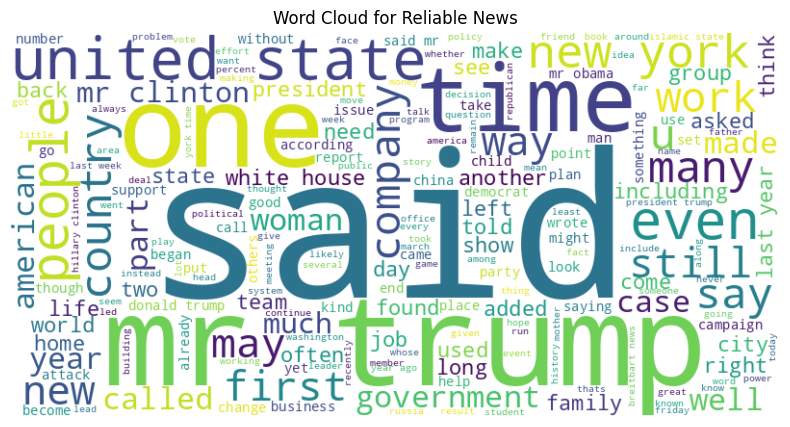

In [17]:
#Data Visualization
#Word Cloud
'''
A word cloud is a data visualization technique that displays the most frequently occurring words in a piece of text data.
It provides a visual representation of text data where the size of each word is proportional to its frequency in the text.
Common words are typically displayed in a larger and bolder font, making them more prominent in the visualization.
'''
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all the text in your dataset (either reliable or unreliable)
text = ' '.join(df[df['label'] == 0]['text'])  # Replace with your dataset

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Reliable News")
plt.show()

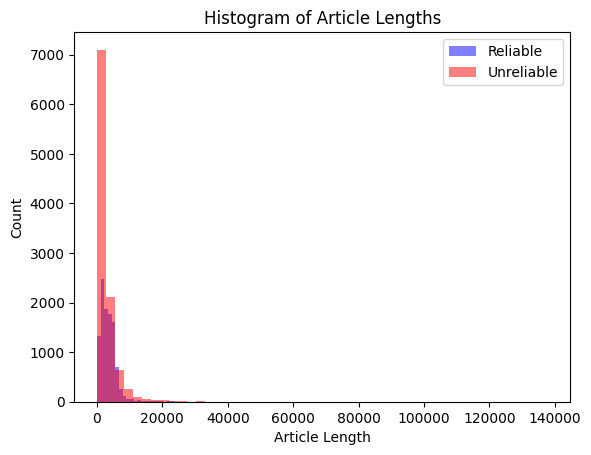

In [18]:
#Histogram of Article Lengths
'''
A histogram for article length is a data visualization that provides insight into the distribution of article lengths within a dataset.
It shows how many articles fall into different length ranges or bins. Each bar in the histogram represents a range of article lengths,
and the height of the bar indicates the number of articles that have lengths within that range.
'''
import matplotlib.pyplot as plt


reliable_articles = df[df['label'] == 0]
unreliable_articles = df[df['label'] == 1]

plt.hist([len(article) for article in reliable_articles['text']], bins=50, alpha=0.5, label='Reliable', color='blue')
plt.hist([len(article) for article in unreliable_articles['text']], bins=50, alpha=0.5, label='Unreliable', color='red')
plt.xlabel('Article Length')
plt.ylabel('Count')
plt.title('Histogram of Article Lengths')
plt.legend(loc='upper right')
plt.show()

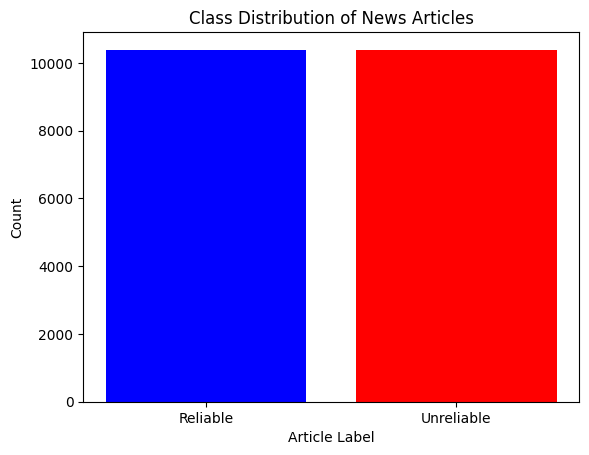

In [19]:
#bar chart
'''
A Bar Chart for Class Distribution is a data visualization that displays the distribution of classes or categories in a dataset.
'''
import matplotlib.pyplot as plt

# Assuming you have a DataFrame with a 'label' column
# df is your processed dataset
reliable_count = df[df['label'] == 0]['label'].count()
unreliable_count = df[df['label'] == 1]['label'].count()

# Create a bar chart
labels = ['Reliable', 'Unreliable']
counts = [reliable_count, unreliable_count]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Article Label')
plt.ylabel('Count')
plt.title('Class Distribution of News Articles')
plt.show()

In [ ]:
!pip install transformers

In [ ]:
# Model training using BERT
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and prepare data for BERT
X_train_encoded = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test_encoded = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=128)
y_train_tensor = torch.tensor(list(y_train))
y_test_tensor = torch.tensor(list(y_test))

# Create DataLoader
train_dataset = TensorDataset(X_train_encoded.input_ids, X_train_encoded.attention_mask, y_train_tensor)
test_dataset = TensorDataset(X_test_encoded.input_ids, X_test_encoded.attention_mask, y_test_tensor)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model and datasets to the GPU
model.to(device)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)


# Define the BERT fine-tuning parameters
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device)
        )
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Average Training Loss: 0.1758
Epoch 2/3, Average Training Loss: 0.0538
Epoch 3/3, Average Training Loss: 0.0199


In [ ]:
# Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = np.argmax(logits.to("cpu").numpy(), axis=1)
        all_preds.extend(preds)

# Calculate accuracy and generate classification report
accuracy = accuracy_score(list(y_test), all_preds)
print(f"Accuracy: {accuracy:.2f}")

classification_rep = classification_report(list(y_test), all_preds)
print(classification_rep)

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2079
           1       0.99      0.97      0.98      2074

    accuracy                           0.98      4153
   macro avg       0.98      0.98      0.98      4153
weighted avg       0.98      0.98      0.98      4153



In [ ]:
output_dir = "/content/gdrive/My Drive/fake_news"

# Save the model to the specified directory in Google Drive
model.save_pretrained(output_dir)

# Save the tokenizer as well
tokenizer.save_pretrained(output_dir)

('/content/gdrive/My Drive/fake_news/tokenizer_config.json',
 '/content/gdrive/My Drive/fake_news/special_tokens_map.json',
 '/content/gdrive/My Drive/fake_news/vocab.txt',
 '/content/gdrive/My Drive/fake_news/added_tokens.json')

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the trained model and tokenizer
model_output_dir = "/content/gdrive/My Drive/fake_news"  # Replace with your model directory
model = BertForSequenceClassification.from_pretrained(model_output_dir)
tokenizer = BertTokenizer.from_pretrained(model_output_dir)

# Title and description
st.title("News Article Classification")
st.write("This app classifies news articles as reliable or unreliable.")

# Text input box
user_input = st.text_area("Enter a news article:")

if st.button("Classify"):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Calculate probabilities using softmax
    probabilities = torch.softmax(logits, dim=1)[0].tolist()

    # Determine the predicted class
    predicted_class = "Unreliable" if logits[0][1] > 0.5 else "Reliable"

    # Display the results
    st.write(f"Classification: {predicted_class}")
    st.write(f"Confidence (Reliable): {probabilities[0]:.2f}")
    st.write(f"Confidence (Unreliable): {probabilities[1]:.2f}")


Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.531s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.132.150.63
npx: installed 22 in 1.586s
your url is: https://floppy-poets-flash.loca.lt
